In [22]:
from pandas import read_csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import networkx as nx
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from IPython.core.display import display, HTML
from pgmpy.independencies.Independencies import IndependenceAssertion
from pgmpy.inference import VariableElimination
from sklearn.preprocessing import LabelEncoder

C:\Users\12967\AppData\Local\Temp\ipykernel_1608\2271566282.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [23]:
df = read_csv("heart.csv")

In [24]:
df.rename(
    columns=({ 'ChestPain': 'ChestPainType', 'RestBP': 'RestingBP', 'Chol':'Cholestrol', 'Fbs': 'FastingBS', 'RestECG':'RestingECG','MaxHR':'MaxHR','ExAng':'ExerciseAngina','Age':'age','Sex':'sex', 'Slope':'ST_Slope','Ca': 'no.ofVes','Thal' : 'Thalassemia','AHD':'HeartAttack', 'Oldpeak':'oldpeak'}), 
    inplace=True,
)
df.head()

,Unnamed: 0,age,sex,ChestPainType,RestingBP,Cholestrol,FastingBS,RestingECG,MaxHR,ExerciseAngina,oldpeak,ST_Slope,no.ofVes,Thalassemia,HeartAttack
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [25]:
df=df.drop('Unnamed: 0', axis=1)
target='HeartAttack'

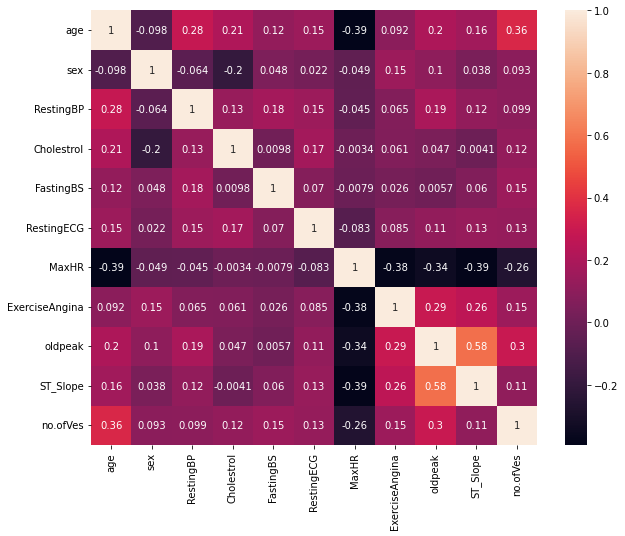

In [26]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [27]:
df['age']=pd.cut(x=df['age'], bins=[np.min(df['age']),35,45,55,65,75,np.max(df['age'])], 
                        labels=["25-35","35-45","45-55","55-65", "65-75", "75-85"])


In [28]:
df['RestingBP']=pd.cut(x=df['RestingBP'], bins=[np.min(df['RestingBP']),110,130,np.max(df['RestingBP'])], 
                        labels=["90-110","110-130","130+"])



In [29]:
df['Cholestrol']=pd.cut(x=df['Cholestrol'], bins=[np.min(df['Cholestrol']),200,240,280,320,np.max(df['Cholestrol'])], 
                        labels=["120-200","200-240","240-280","280-320","320+"])

In [30]:
df['MaxHR']=pd.cut(x=df['MaxHR'], bins=[np.min(df['MaxHR']),99,132,160,np.max(df['MaxHR'])], 
                        labels=["70-99","99-130","130-160","160-205"])

In [31]:
df['oldpeak']=pd.cut(x=df['oldpeak'], bins=[np.min(df['oldpeak']),1.5,2.5,np.max(df['oldpeak'])], 
                        labels=["0-1.5","1.5-2.5","2.5-6"])

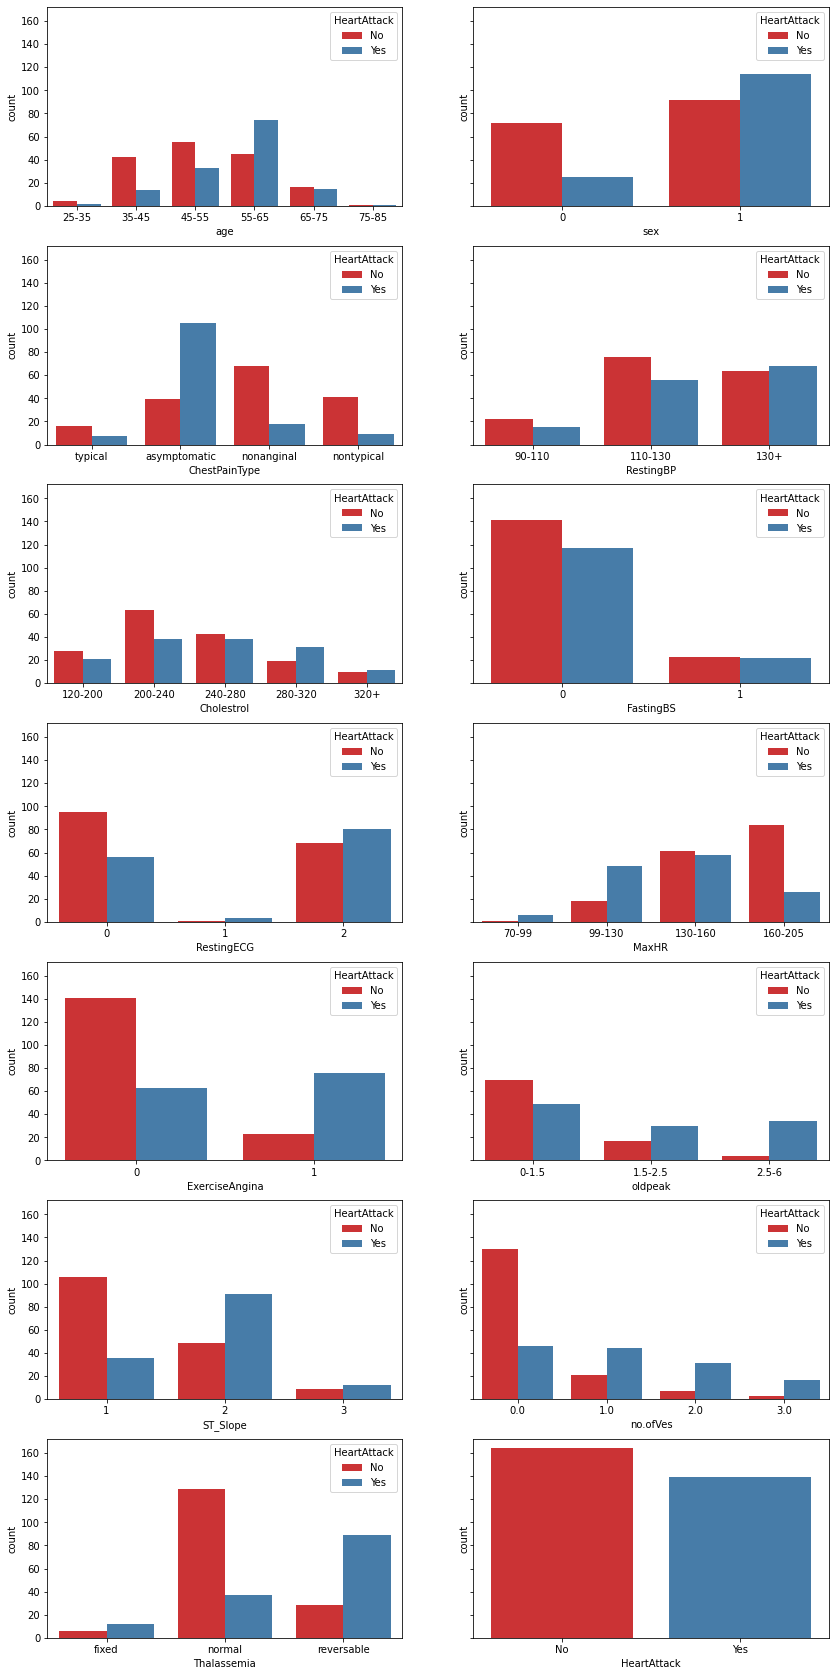

In [32]:
_, axes = plt.subplots(nrows=7, ncols=2, figsize=(14, 30), sharey=True)
axes = [axis for subl in axes for axis in subl]
for col, ax in zip(df.columns, axes):
    if col != target:
        sns.countplot(x=col, hue="HeartAttack", data=df, ax=ax, palette="Set1")
    else:
        sns.countplot(x=col, data=df, ax=ax, palette="Set1")

### Создаем связи вручную

In [33]:
model=BayesianNetwork([('age', 'RestingBP'),('age', 'MaxHR'),('age', 'Cholestrol'),
                       ('sex', 'Cholestrol'),('sex','MaxHR'),('sex','RestingBP'),
                       ('Cholestrol', 'ChestPainType'),('Cholestrol', 'RestingBP'),('Cholestrol', 'MaxHR'),
                       ('FastingBS', 'Cholestrol'),
                       ('RestingBP', 'MaxHR'),('RestingBP', 'ChestPainType'),
                       ('Thalassemia', 'FastingBS'),('Thalassemia', 'MaxHR'),('Thalassemia', 'ExerciseAngina'),('Thalassemia', 'Cholestrol'),
                       ('no.ofVes', 'RestingBP'),('MaxHR', 'ExerciseAngina'),
                       ('oldpeak', 'ST_Slope'),('oldpeak', 'ExerciseAngina'),('oldpeak', 'RestingECG'),
                       ('Cholestrol', 'HeartAttack'),('ChestPainType', 'HeartAttack'),('RestingBP', 'HeartAttack')])

In [34]:
model

In [35]:
print('Nodes',model.nodes(),'\n')

Nodes ['age', 'RestingBP', 'MaxHR', 'Cholestrol', 'sex', 'ChestPainType', 'FastingBS', 'Thalassemia', 'ExerciseAngina', 'no.ofVes', 'oldpeak', 'ST_Slope', 'RestingECG', 'HeartAttack'] 



In [36]:
print('Edges',model.edges())

Edges [('age', 'RestingBP'), ('age', 'MaxHR'), ('age', 'Cholestrol'), ('RestingBP', 'MaxHR'), ('RestingBP', 'ChestPainType'), ('RestingBP', 'HeartAttack'), ('MaxHR', 'ExerciseAngina'), ('Cholestrol', 'ChestPainType'), ('Cholestrol', 'RestingBP'), ('Cholestrol', 'MaxHR'), ('Cholestrol', 'HeartAttack'), ('sex', 'Cholestrol'), ('sex', 'MaxHR'), ('sex', 'RestingBP'), ('ChestPainType', 'HeartAttack'), ('FastingBS', 'Cholestrol'), ('Thalassemia', 'FastingBS'), ('Thalassemia', 'MaxHR'), ('Thalassemia', 'ExerciseAngina'), ('Thalassemia', 'Cholestrol'), ('no.ofVes', 'RestingBP'), ('oldpeak', 'ST_Slope'), ('oldpeak', 'ExerciseAngina'), ('oldpeak', 'RestingECG')]


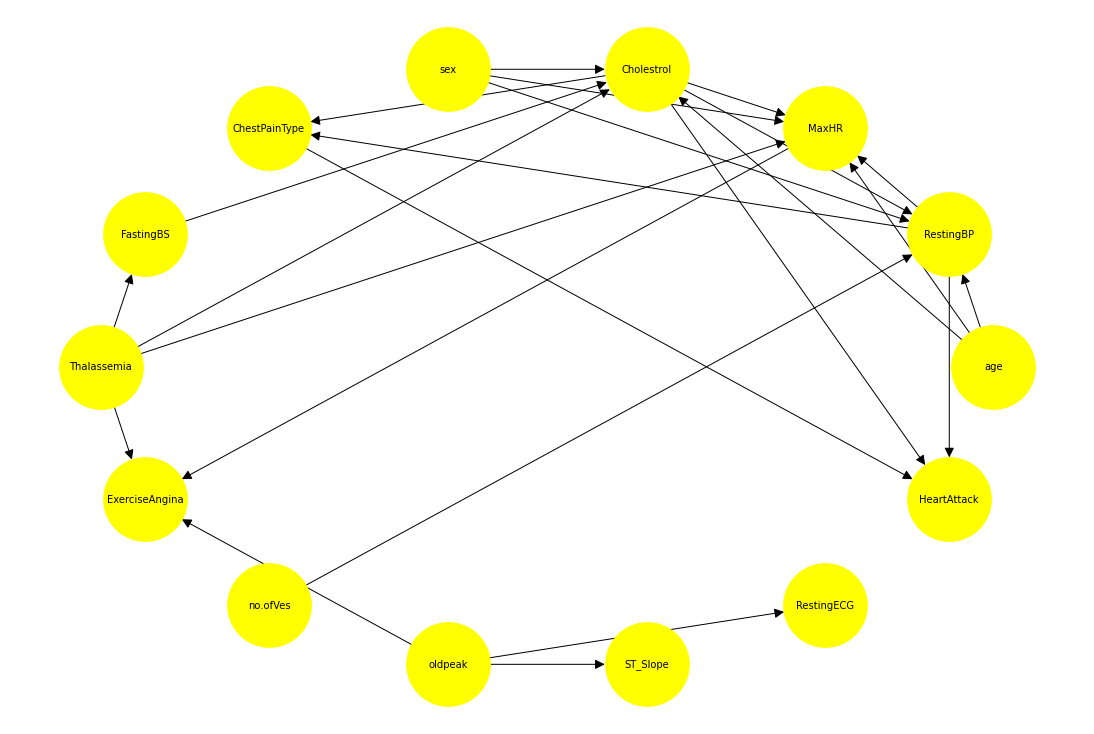

In [37]:
plt.figure(figsize=(15,10))
nx.draw_circular(model, with_labels=True, arrowsize=20, node_size=7000, font_size=10,node_color='yellow')
plt.show()

In [38]:
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

model.cpds = []
model.fit(data=df,
          estimator=BayesianEstimator,
          prior_type="BDeu",
          equivalent_sample_size=10,
          complete_samples_only=False)

print(f'Check model: {model.check_model()}\n')
for cpd in model.get_cpds():
    print(f'CPD of {cpd.variable}:')
    print(cpd, '\n')

Check model: True

CPD of age:
+------------+-----------+
| age(25-35) | 0.0245726 |
+------------+-----------+
| age(35-45) | 0.184829  |
+------------+-----------+
| age(45-55) | 0.287393  |
+------------+-----------+
| age(55-65) | 0.386752  |
+------------+-----------+
| age(65-75) | 0.104701  |
+------------+-----------+
| age(75-85) | 0.0117521 |
+------------+-----------+ 

CPD of RestingBP:
+--------------------+----------------------+-----+--------------------+--------------------+
| Cholestrol         | Cholestrol(120-200)  | ... | Cholestrol(320+)   | Cholestrol(320+)   |
+--------------------+----------------------+-----+--------------------+--------------------+
| age                | age(25-35)           | ... | age(75-85)         | age(75-85)         |
+--------------------+----------------------+-----+--------------------+--------------------+
| no.ofVes           | no.ofVes(0.0)        | ... | no.ofVes(3.0)      | no.ofVes(3.0)      |
+--------------------+------------

### Генерируем связи

In [39]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore
est=HillClimbSearch(df)

In [40]:
est_model=est.estimate(scoring_method=BDeuScore(df),  max_iter=100, epsilon=1e-6)

  0%|          | 0/100 [00:00<?, ?it/s]

In [45]:
G=est_model.to_directed()
print(G.edges(), sep='\n')


[('sex', 'Thalassemia'), ('sex', 'HeartAttack'), ('ChestPainType', 'MaxHR'), ('ChestPainType', 'ExerciseAngina'), ('oldpeak', 'ST_Slope'), ('ST_Slope', 'RestingECG'), ('Thalassemia', 'HeartAttack'), ('Thalassemia', 'FastingBS'), ('HeartAttack', 'ChestPainType'), ('HeartAttack', 'no.ofVes'), ('HeartAttack', 'ExerciseAngina'), ('HeartAttack', 'oldpeak'), ('HeartAttack', 'ST_Slope'), ('HeartAttack', 'age')]


In [47]:
df

,age,sex,ChestPainType,RestingBP,Cholestrol,FastingBS,RestingECG,MaxHR,ExerciseAngina,oldpeak,ST_Slope,no.ofVes,Thalassemia,HeartAttack
0,55-65,1,typical,130+,200-240,1,2,130-160,0,1.5-2.5,3,0.0,fixed,No
1,65-75,1,asymptomatic,130+,280-320,0,2,99-130,1,0-1.5,2,3.0,normal,Yes
2,65-75,1,asymptomatic,110-130,200-240,0,2,99-130,1,2.5-6,2,2.0,reversable,Yes
3,35-45,1,nonanginal,110-130,240-280,0,0,160-205,0,2.5-6,3,0.0,normal,No
4,35-45,0,nontypical,110-130,200-240,0,2,160-205,0,0-1.5,1,0.0,normal,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,35-45,1,typical,90-110,240-280,0,0,99-130,0,0-1.5,2,0.0,reversable,Yes
299,65-75,1,asymptomatic,130+,120-200,1,0,130-160,0,2.5-6,2,2.0,reversable,Yes
300,55-65,1,asymptomatic,110-130,120-200,0,0,99-130,1,0-1.5,2,1.0,reversable,Yes
301,55-65,0,nontypical,110-130,200-240,0,2,160-205,0,NaN,2,1.0,normal,Yes


In [48]:
model_2=BayesianNetwork([('sex', 'Thalassemia'),('sex', 'HeartAttack'),('ChestPainType', 'MaxHR'),
                       ('ChestPainType', 'ExerciseAngina'), ('oldpeak', 'ST_Slope'), ('ST_Slope', 'RestingECG'), 
                      ('Thalassemia', 'HeartAttack'), ('Thalassemia', 'FastingBS'), ('HeartAttack', 'ChestPainType'),
                       ('HeartAttack', 'no.ofVes'), ('HeartAttack', 'ExerciseAngina'), ('HeartAttack', 'oldpeak'),
                       ('HeartAttack', 'ST_Slope'), ('HeartAttack', 'age')])

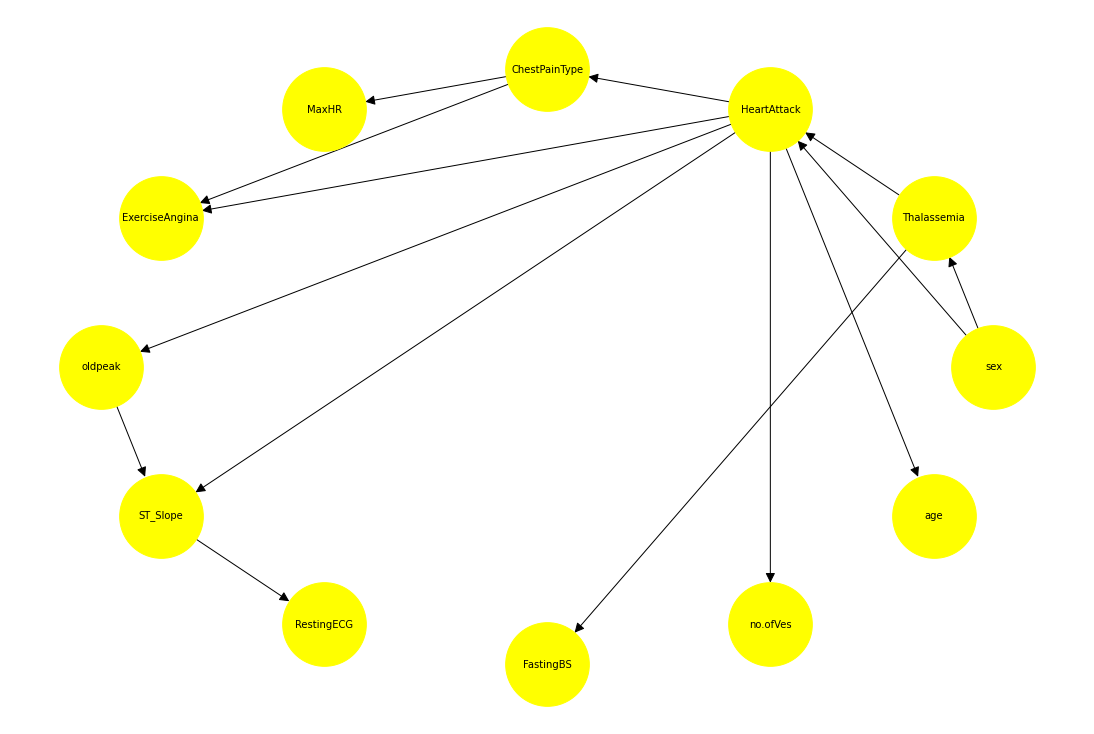

In [49]:
plt.figure(figsize=(15,10))
nx.draw_circular(model_2, with_labels=True, arrowsize=20, node_size=7000, font_size=10,node_color='yellow')
plt.show()